In this video, we'll explore different embedding models available in the Sentence Transformers ecosystem and understand their trade-offs.

Embedding models differ in many ways, including:
1. Size and computational requirements
2. Language support (monolingual vs. multilingual)
3. Context length limitations
4. Embedding dimensionality 
5. Performance on specific tasks

Sentence Transformers provides access to a wide range of pre-trained models optimized for different use cases. Some popular models include:

- all-MiniLM-L6-v2: A compact, efficient model that produces 384-dimensional embeddings
- all-mpnet-base-v2: A more powerful model with 768-dimensional embeddings
- paraphrase-multilingual-MiniLM-L12-v2: Supports 50+ languages
- multi-qa-mpnet-base-dot-v1: Optimized for question-answering tasks

When selecting an embedding model for your application, consider these factors:

1. Accuracy requirements: More powerful models typically produce better embeddings but require more computation
2. Inference speed: Smaller models are faster but may sacrifice some accuracy
3. Resource constraints: Model size affects memory usage and deployment options
4. Multilingual needs: Some models support multiple languages, while others are optimized for English
5. Specific tasks: Models fine-tuned for particular tasks often perform better on those tasks

Let's compare several embedding models to understand their trade-offs in a real-world production context.

                                Model  Dimensions  Size (MB)  Load Time (s)  Encoding Time (s)  Total Time (s)  Similar Pair Similarity  Different Pair Similarity  Contrast
                     all-MiniLM-L6-v2         384  86.644043       0.432152           0.029452        0.462517                 0.537720                   0.054547  0.483173
                    all-MiniLM-L12-v2         384 127.258301       0.398189           0.152330        0.551222                 0.600507                   0.175118  0.425388
                    all-mpnet-base-v2         768 417.657715       0.397943           0.633341        1.032193                 0.659811                   0.036776  0.623036
paraphrase-multilingual-MiniLM-L12-v2         384 448.813477       1.106946           0.193884        1.301800                 0.513916                   0.154445  0.359471


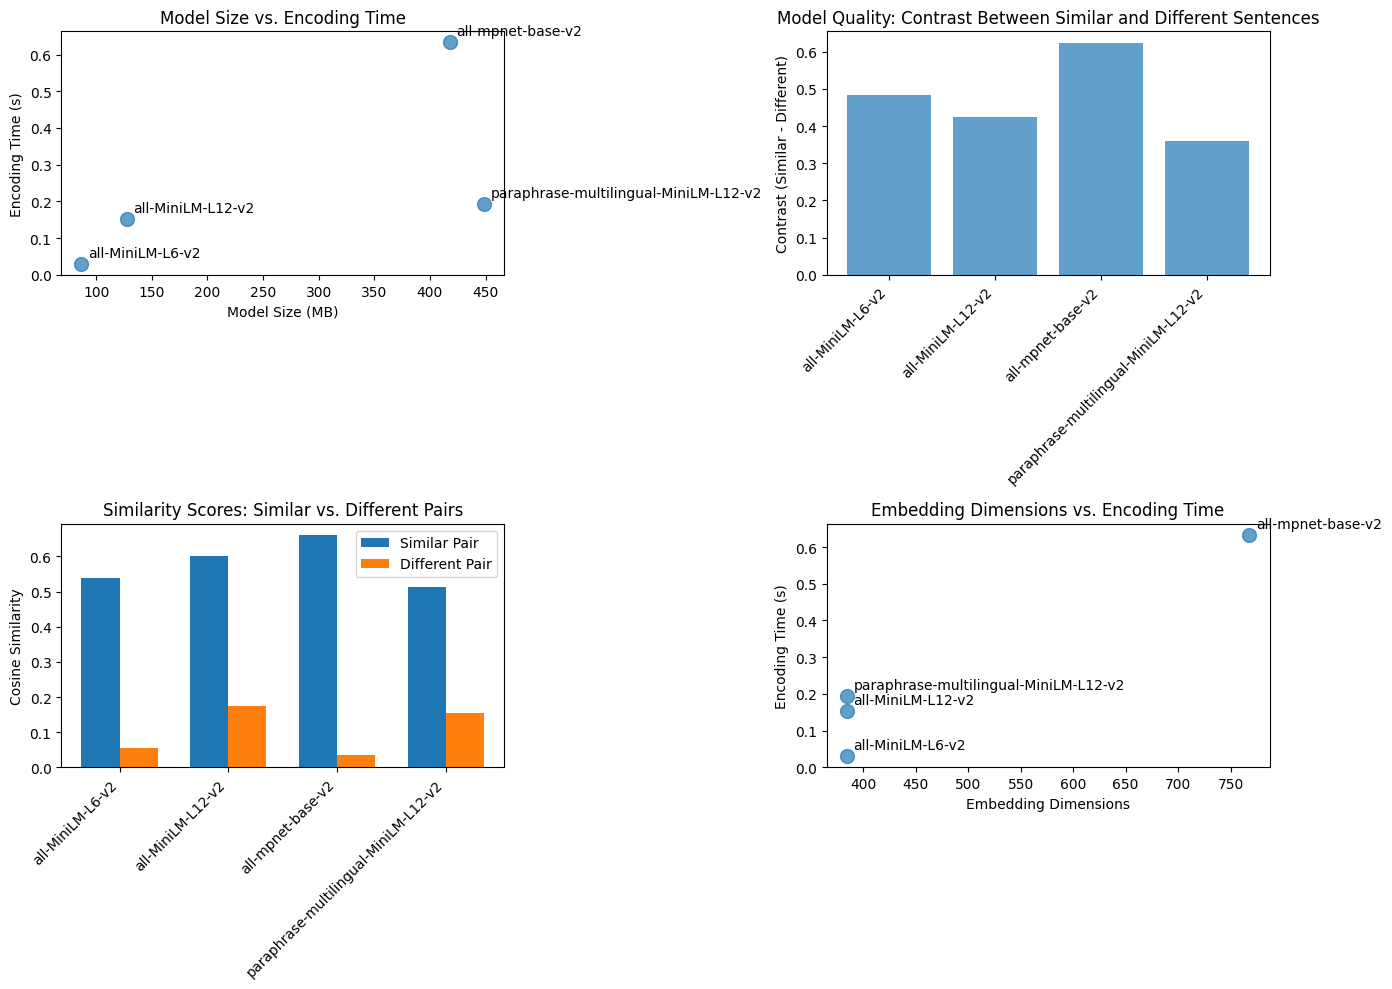

In [ ]:
import random
from sentence_transformers import SentenceTransformer, util
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set a nice visual style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 11})

# Different embeddings models
models = [
    'all-MiniLM-L6-v2',  # Small model (384d)
    'all-MiniLM-L12-v2',  # Medium model (384d)
    'all-mpnet-base-v2',  # Large model (768d)
    'paraphrase-multilingual-MiniLM-L12-v2'  # Multilingual model (384d)
]

# Example sentences for benchmarking, organized by topic pairs
sentence_pairs = [
    # Technology pairs (semantically similar)
    ["Machine learning models require significant computational resources.",
     "AI systems need a lot of computing power to train."],

    # Programming pairs (semantically similar)
    ["What's the best algorithm for text classification?",
     "How can I optimize my neural network training time?"],

    # Weather pairs (semantically similar)
    ["The weather forecast predicts rain tomorrow.",
     "It's going to be wet outside tomorrow according to meteorologists."],

    # Office pairs (semantically similar)
    ["I need to get a new computer for my office.",
     "My workplace needs updated computing equipment."],

    # Health pairs (semantically similar)
    ["Regular exercise improves cardiovascular health.",
     "Working out frequently is good for your heart."],

    # Food pairs (semantically similar)
    ["The restaurant serves authentic Italian pasta dishes.",
     "You can get genuine Italian noodle recipes at that dining place."]
]

# Generate dissimilar pairs by mixing topics
dissimilar_pairs = []
for i in range(len(sentence_pairs)):
    for j in range(len(sentence_pairs)):
        if i != j:  # Different topics
            dissimilar_pairs.append(
                [sentence_pairs[i][0], sentence_pairs[j][0]])

# Just use 6 dissimilar pairs to match our similar pairs count
random.seed(42)  # For reproducibility
dissimilar_pairs = random.sample(dissimilar_pairs, 6)

# Create flat list of all sentences for encoding
all_sentences = []
for pair in sentence_pairs + dissimilar_pairs:
    all_sentences.extend(pair)
all_sentences = list(set(all_sentences))  # Remove duplicates

results = []

# Evaluation loop
for model_name in models:
    start_time = time.time()

    # Load model
    model_load_time = time.time()
    model = SentenceTransformer(model_name)
    model_load_time = time.time() - model_load_time

    # Encode all sentences at once (more efficient)
    encoding_time = time.time()
    embeddings_dict = {sentence: model.encode(
        sentence) for sentence in all_sentences}
    encoding_time = time.time() - encoding_time

    # Calculate embedding dimensionality
    dim = next(iter(embeddings_dict.values())).shape[0]

    # Get model size (parameters)
    model_size_mb = sum(p.numel() for p in model.parameters()
                        ) * 4 / 1024 / 1024  # Approx size in MB

    # Calculate similarities for similar pairs
    similar_scores = []
    for s1, s2 in sentence_pairs:
        score = util.cos_sim(
            embeddings_dict[s1].reshape(1, -1),
            embeddings_dict[s2].reshape(1, -1)
        ).item()
        similar_scores.append(score)

    # Calculate similarities for dissimilar pairs
    dissimilar_scores = []
    for s1, s2 in dissimilar_pairs:
        score = util.cos_sim(
            embeddings_dict[s1].reshape(1, -1),
            embeddings_dict[s2].reshape(1, -1)
        ).item()
        dissimilar_scores.append(score)

    # Calculate average scores and contrast
    avg_similar = sum(similar_scores) / len(similar_scores)
    avg_dissimilar = sum(dissimilar_scores) / len(dissimilar_scores)
    contrast = avg_similar - avg_dissimilar

    total_time = time.time() - start_time

    # Store results
    results.append({
        'Model': model_name,
        'Dimensions': dim,
        'Size (MB)': model_size_mb,
        'Load Time (s)': model_load_time,
        'Encoding Time (s)': encoding_time,
        'Total Time (s)': total_time,
        'Avg Similar Score': avg_similar,
        'Avg Different Score': avg_dissimilar,
        'Contrast': contrast,
        'Similar Scores': similar_scores,
        'Dissimilar Scores': dissimilar_scores
    })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(results)

# Create a more readable version of the results for display
display_df = df[['Model', 'Dimensions', 'Size (MB)', 'Encoding Time (s)',
                'Avg Similar Score', 'Avg Different Score', 'Contrast']]
print("\n=== Model Comparison Summary ===")
print(display_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Detailed pair analysis
print("\n=== Detailed Pair Analysis ===")
for idx, model_data in enumerate(results):
    print(f"\nModel: {model_data['Model']}")
    print("Similar pairs:")
    for i, score in enumerate(model_data['Similar Scores']):
        print(
            f"  - Pair {i+1}: {sentence_pairs[i][0]} | {sentence_pairs[i][1]} | Score: {score:.4f}")
    print("Dissimilar pairs:")
    for i, score in enumerate(model_data['Dissimilar Scores']):
        print(
            f"  - Pair {i+1}: {dissimilar_pairs[i][0]} | {dissimilar_pairs[i][1]} | Score: {score:.4f}")

# Visualize model comparison with improved plots
plt.figure(figsize=(20, 16))

# Plot 1: Model Performance Dashboard
plt.subplot(2, 2, 1)
# Create x-axis with model names
x = np.arange(len(models))
width = 0.25

# Plot bars for each metric
plt.bar(x - width, df['Avg Similar Score'], width,
        label='Avg Similar Score', color='green', alpha=0.7)
plt.bar(x, df['Avg Different Score'], width,
        label='Avg Different Score', color='red', alpha=0.7)
plt.bar(x + width, df['Contrast'], width,
        label='Contrast', color='blue', alpha=0.7)

plt.xticks(x, df['Model'], rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Similar vs Different distribution
plt.subplot(2, 2, 2)

# Prepare data for boxplot
boxplot_data = []
model_names = []

for model_data in results:
    boxplot_data.append(model_data['Similar Scores'])
    boxplot_data.append(model_data['Dissimilar Scores'])
    model_names.append(f"{model_data['Model']} Similar")
    model_names.append(f"{model_data['Model']} Different")

# Create a color map for the boxes
colors = ['lightgreen', 'lightcoral'] * len(models)

# Create boxplot
bp = plt.boxplot(boxplot_data, patch_artist=True, vert=False)
plt.yticks(range(1, len(model_names) + 1), model_names)
plt.xlabel('Cosine Similarity')
plt.title('Distribution of Similarity Scores by Model')

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot 3: Efficiency metrics - bubble chart
plt.subplot(2, 2, 3)
plt.scatter(df['Size (MB)'], df['Encoding Time (s)'],
            s=df['Dimensions']/5, alpha=0.7)
for i, model in enumerate(df['Model']):
    plt.annotate(model, (df['Size (MB)'].iloc[i], df['Encoding Time (s)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Model Size (MB)')
plt.ylabel('Encoding Time (s)')
plt.title('Model Efficiency (bubble size = dimensions)')
plt.grid(True)

# Plot 4: Performance vs Resource Requirements
plt.subplot(2, 2, 4)
sc = plt.scatter(df['Total Time (s)'], df['Contrast'], c=df['Size (MB)'],
                 s=200, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Model Size (MB)')

for i, model in enumerate(df['Model']):
    plt.annotate(model, (df['Total Time (s)'].iloc[i], df['Contrast'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Total Processing Time (s)')
plt.ylabel('Contrast (Similar - Different)')
plt.title('Performance vs. Resource Requirements')
plt.grid(True)

plt.tight_layout(pad=3.0)
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Takeaways

- Contrast is king: The contrast score is often the most important metric. A model with higher contrast will be better at distinguishing relevant from irrelevant information.
- Consider the trade-offs: Larger models typically have better semantic understanding but require more resources and run slower. Ask yourself what's more important for your application: accuracy or speed?
- Test with domain-specific data: While our comparison uses general examples, you'll get the best results by testing with examples from your specific domain.
- Think about your constraints: If you're deploying on mobile or edge devices, model size matters more. For server applications, you might prioritize accuracy.
- Consider multilingual needs: If your application needs to work across languages, a multilingual model might be essential even if it's not the top performer in English.
